## Imports

In [49]:
# import qiskit

# from qiskit_nature.second_q import hamiltonians, operators
# from qiskit_nature.second_q.hamiltonians import lattices 
# from qiskit_nature.second_q.mappers import LinearMapper
# from qiskit_nature.second_q.hamiltonians.lattices.boundary_condition import BoundaryCondition
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.instruction import Instruction
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.states import Statevector
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Estimator

import numpy as np
from numpy.linalg import eig, norm
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from itertools import combinations, chain

In [50]:
NUM_STATES_2_QUBITS = 4
NUM_MUBS_2_QUBITS = 5
NUM_STATES_3_QUITS = 8
NUM_MUBS_3_QUBTIS = 9

## Generate transverse-field Ising operator

I started by using the qiskit_nature.second_q module. That proved to be a mistake once I want to move to qubits,
because their move is not trivial.

The following is an implementation of the operators in SparsePauliOp form directly.

In [51]:
def gen_trans_ising_op(num_qubits: int, zz_coeff: float, x_coeff: float, toric_bounds: bool=False) -> SparsePauliOp:
    terms = []
    coeffs = []
    # Adding the ZZ terms
    for i in range(num_qubits if toric_bounds else num_qubits-1):
        curr_term = ['I'] * num_qubits
        curr_term[i] = 'Z'
        curr_term[(i+1)%num_qubits] = 'Z'
        terms.append(''.join(curr_term))
        coeffs.append(zz_coeff)
    # Adding the X terms
    for i in range(num_qubits):
        curr_term = ['I'] * num_qubits
        curr_term[i] = 'X'
        terms.append(''.join(curr_term))
        coeffs.append(x_coeff)
    
    return SparsePauliOp(terms, coeffs)

## Get exact answers

### A question of goals
In the origianl formulation, the goal of VQE is to find the lowest eigenvalue.
The tricky part is that numpy does not guarantee any ordering of the eigenvalues and eigenvectors. So that's on us.

In [52]:
def get_exact_ground(op: SparsePauliOp) -> np.float64:
    eig_res = eig(op.to_matrix())
    return min(eig_res.eigenvalues).real

## Get expectation value over specific state-vector

In [53]:
def get_expectation_value(state: Statevector, op: SparsePauliOp) -> np.float64:
    return np.round(state.expectation_value(op).real, 10)

## Generate MUB statevectors
This is done using Dekel's current notebook code.
The code is, for lack of a better word, bad.
I will attempt to prepare it in a cleaner and more robust way.
But for now, let's check that the most basic way still works.

In [55]:
# Adds Y-Hadamard gate on qubit q in circ
def yh(circ, q):
    circ.h(q)
    circ.s(q)

def prep_MUB(circ, state_idx, mub_idx, qubit_subset = [0,1]):
    assert len(qubit_subset) == 2
    assert (0 <= state_idx <= 3)
    assert (0 <= mub_idx <= 4)
    # state_idx chooses the state in the basis (MUB)
    if state_idx == 1:
        circ.x(qubit_subset[0])
    elif state_idx == 2:
        circ.x(qubit_subset[1])
    elif state_idx == 3:
        circ.x(qubit_subset[0])
        circ.x(qubit_subset[1])
        
    # mub_idx chooses the basis (MUB) itself
    if mub_idx == 1:
        circ.h(qubit_subset[0])
        circ.h(qubit_subset[1])
    elif mub_idx == 2:
        circ.h(qubit_subset[0])
        yh(circ,qubit_subset[1])
        circ.cz(qubit_subset[0], qubit_subset[1])
    elif mub_idx == 3:
        yh(circ,qubit_subset[0])
        yh(circ,qubit_subset[1])
    elif mub_idx == 4:
        yh(circ,qubit_subset[0])
        circ.h(qubit_subset[1])
        circ.cz(qubit_subset[0], qubit_subset[1])
        
def prep_MUB3(circ, state_idx, mub_idx, qubit_subset = [0,1,2]):
    # state_idx chooses the state in the basis (MUB)
    if state_idx == 1:
        circ.x(qubit_subset[0])
    elif state_idx == 2:
        circ.x(qubit_subset[1])
    elif state_idx == 3:
        circ.x(qubit_subset[0])
        circ.x(qubit_subset[1])
    elif state_idx == 4:
        circ.x(qubit_subset[2])
    elif state_idx == 5:
        circ.x(qubit_subset[0])
        circ.x(qubit_subset[2])
    elif state_idx == 6:
        circ.x(qubit_subset[1])
        circ.x(qubit_subset[2])
    elif state_idx == 7:
        circ.x(qubit_subset[0])
        circ.x(qubit_subset[1])
        circ.x(qubit_subset[2])
    
    # mub_idx chooses the basis (MUB) itself
    if mub_idx == 1:
        circ.h(qubit_subset[0])
        circ.h(qubit_subset[1])
        circ.h(qubit_subset[2])
    elif mub_idx == 2:
        yh(circ, qubit_subset[0])
        yh(circ, qubit_subset[1])
        yh(circ, qubit_subset[2])
    elif mub_idx == 3:
        yh(circ, qubit_subset[0])
        circ.h(qubit_subset[1])
        circ.h(qubit_subset[2])
        circ.cz(qubit_subset[1], qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[1])
    elif mub_idx == 4:
        circ.h(qubit_subset[0])
        yh(circ, qubit_subset[1])
        circ.h(qubit_subset[2])
        circ.cz(qubit_subset[1], qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[2])
    elif mub_idx == 5:
        circ.h(qubit_subset[0])
        circ.h(qubit_subset[1])
        yh(circ, qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[1])
        circ.cz(qubit_subset[0], qubit_subset[2])
    elif mub_idx == 6:
        yh(circ, qubit_subset[0])
        yh(circ, qubit_subset[1])
        circ.h(qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[1])
        circ.cz(qubit_subset[0], qubit_subset[2])
    elif mub_idx == 7:
        yh(circ, qubit_subset[0])
        circ.h(qubit_subset[1])
        yh(circ, qubit_subset[2])
        circ.cz(qubit_subset[1], qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[2])
    elif mub_idx == 8:
        circ.h(qubit_subset[0])
        yh(circ, qubit_subset[1])
        yh(circ, qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[1])
        circ.cz(qubit_subset[1], qubit_subset[2])

The field `state_idx` chooses the state *inside* the MUB.  
The field `mub_idx` chooses the basis.   
The field `qubit_subset` chooses the subset of qubit_subset over which to generate the MUB state.   

In [56]:
def generate_mub_state(state_idx: int, mub_idx: int, num_qubits: int, qubit_subset: list[int],
                        plus_for_non_mub=False) -> tuple[QuantumCircuit, np.ndarray]:
    circuit = QuantumCircuit(num_qubits)
    if len(qubit_subset) == 2:
        prep_MUB(circuit, state_idx, mub_idx, qubit_subset)
    elif len(qubit_subset) == 3:
        prep_MUB3(circuit, state_idx, mub_idx, qubit_subset)
    else:
        raise Exception("We do not support this size of MUB states.")
    if plus_for_non_mub:
        for qubit in range(num_qubits):
            if qubit not in qubit_subset:
                circuit.h(qubit)
    state = Statevector.from_instruction(circuit)
    return circuit, state

# Attempt all states over a hamiltonian

## Result heirarchy
The list heirarchy is defined by the following indexes, in this order:
1. MUB used.
2. Subset of qubits on which this MUB was applied.
3. The specific MUB states.

In [57]:
def generate_all_subsets(n_mub_qubits: int, n_qubits: int) -> list[tuple[int]]:
    return list(combinations(np.linspace(0, n_qubits-1, n_qubits, dtype=int), n_mub_qubits))

In [58]:
LandscapeResultType = list[list[list[tuple[QuantumCircuit, np.float64]]]]

def calculate_energy_landscape(op: SparsePauliOp, n_mub_qubits: int, subset_list: list[tuple],
                                plus_for_non_mub=False) -> LandscapeResultType:
    num_states = num_mubs = 0
    if n_mub_qubits == 2:
        num_states = NUM_STATES_2_QUBITS
        num_mubs = NUM_MUBS_2_QUBITS
    elif n_mub_qubits == 3:
        num_states = NUM_STATES_3_QUITS
        num_mubs = NUM_MUBS_3_QUBTIS
    else:
        raise Exception("We do not support this size of MUB states.")

    total_res = []
    for mub_idx in range(num_mubs):
        mub_res = []
        for subset in subset_list:
            subset_res = []
            for state_idx in range(num_states):
                circuit, state = generate_mub_state(state_idx, mub_idx, op.num_qubits, subset, plus_for_non_mub)
                res = get_expectation_value(state, op)
                subset_res.append((circuit, res))
            mub_res.append(subset_res)
        total_res.append(mub_res)
    return total_res

def flatten_energies(results):
    flat_res = []
    for mub_res in results:
        for subset_res in mub_res:
            flat_res += [energy for circuit, energy in subset_res]
    return flat_res

## Graph display code

In [59]:
FIG_SIZE = (8,5)
def display_energy_landscape(energy_landscape_results: LandscapeResultType, exact_result: np.float64, graph_title="Energy landscape",
                                show_legend=False):
    fig = plt.figure(figsize=FIG_SIZE)
    idx_counter = 0
    basis_size = len(results[0][0])
    mub_results_size = basis_size * len(results[0])
    for i, mub_res in enumerate(results):
        for j, subset_res in enumerate(mub_res):
            energies_only = [energy for circuit, energy in subset_res]
            plt.plot(list(range(idx_counter, idx_counter+basis_size)), energies_only, 'o', lw=0.4, label=f"MUB {i}, subset {j}")
            idx_counter += basis_size
        # Show separation between different MUBs
        plt.axvspan(idx_counter - mub_results_size, idx_counter, alpha=0.1, color=f"C{i}")
    # Show exact result
    plt.axhline(y=exact_result, lw=0.6, color='red')
    # Show comp. basis specifically
    xmin, xmax, ymin, ymax = plt.axis()
    plt.text(x=basis_size*0.25, y=ymin + (ymax-ymin)*0.8, s='COMP', fontsize=10)
    
    plt.xlabel("MUB state index")
    plt.ylabel("Cost function result")
    if show_legend:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(graph_title)
    plt.show()

def display_energy_histogram(energy_landscape_results: LandscapeResultType, exact_result: np.float64, bins=100,
                                graph_title="Energy landscape histogram", show_legend=False):
    fig = plt.figure(figsize=FIG_SIZE)
    plt.locator_params(axis='x', nbins=min(bins//2, 30), tight=True)
    plt.xticks(fontsize=10, rotation=60)
    plt.locator_params(axis='y', nbins=10)

    flat_results = flatten_energies(energy_landscape_results)
    plt.hist(flat_results, bins)
    # Show exact result
    plt.axvline(x=exact_result, lw=1, color='red')

    plt.xlabel("Cost function result")
    plt.ylabel("number of results")
    if show_legend:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(graph_title)
    plt.show()

## Example: generate operator, calculate landscape, show results

In [60]:
n_qubits = 2
n_mub_qubits = 2

zz_coeff = random.uniform(0,1)
x_coeff = random.uniform(0,1)
op = gen_trans_ising_op(n_qubits, zz_coeff, x_coeff)
print(f"attempting all MUB states over the operator {op}")
results = calculate_energy_landscape(op, n_mub_qubits, generate_all_subsets(n_mub_qubits, n_qubits))
exact_result = get_exact_ground(op)

attempting all MUB states over the operator SparsePauliOp(['ZZ', 'XI', 'IX'],
              coeffs=[0.78218427+0.j, 0.97603379+0.j, 0.97603379+0.j])


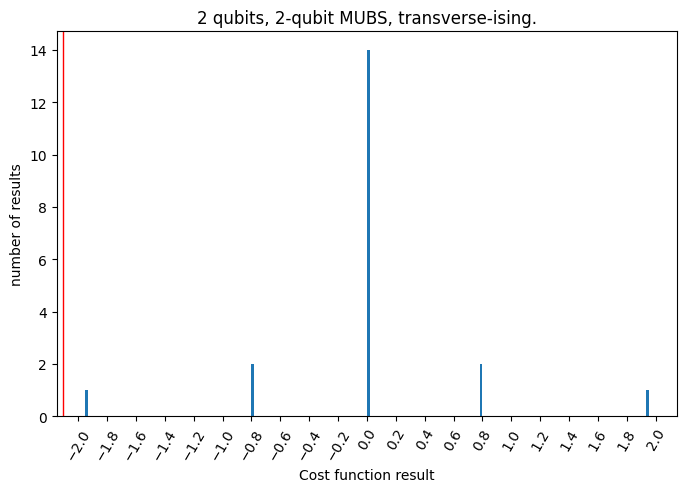

In [61]:
display_energy_histogram(results, exact_result, graph_title=f"{n_qubits} qubits, {n_mub_qubits}-qubit MUBS, transverse-ising.", bins=200)

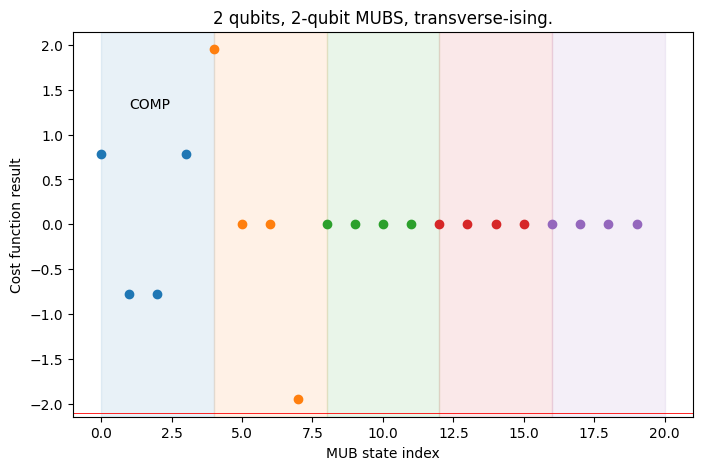

In [62]:
display_energy_landscape(results, exact_result, graph_title=f"{n_qubits} qubits, {n_mub_qubits}-qubit MUBS, transverse-ising.")

## Convincing results
What results dfo I want o show Tal and Dekel so they'll be convicned that what I did here shows anything?

1.  Show that when genrating 3-qubit full-MUB states using Trasnverse Ising, the best starting points are *clearly* not in the comp. basis.
    Do so by giving 2-3 examples of such generated Hamiltonians.

2.  Show that the rest of the results bunch around a VERY specific area in the cost, perhaps indicating a BP.
    Another, more pessimistic way to see this is that MUBs only give an advantage in a very small number of cases.
    Use the same graphs.

3.  Show that when we do Half-MUBs, the answers drastically drift away from the correct result. However, non-comps still lead to victory.
    Do so by giving 4-5 graphs with increasing qubit count, showing the distinct difference.

attempting all MUB states over the operator SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IIX'],
              coeffs=[0.47054433+0.j, 0.47054433+0.j, 0.79522594+0.j, 0.79522594+0.j,
 0.79522594+0.j])
Energy Landscape:


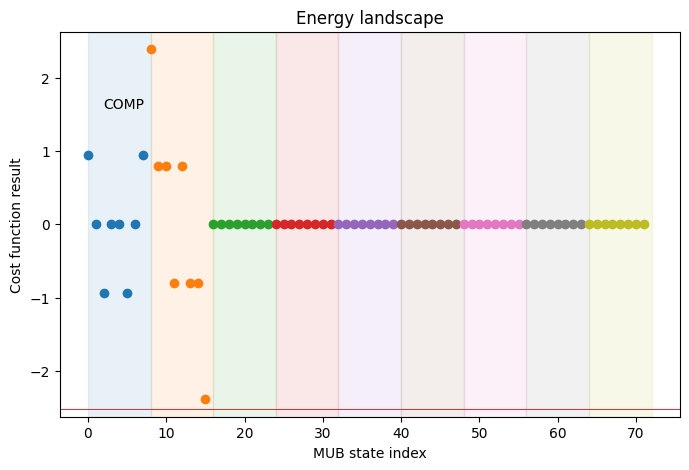

Energy Histogram:


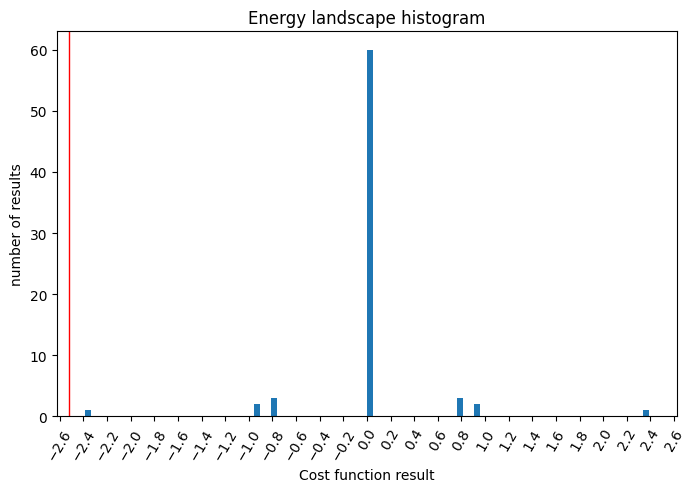

attempting all MUB states over the operator SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IIX'],
              coeffs=[0.46580808+0.j, 0.46580808+0.j, 0.49054819+0.j, 0.49054819+0.j,
 0.49054819+0.j])
Energy Landscape:


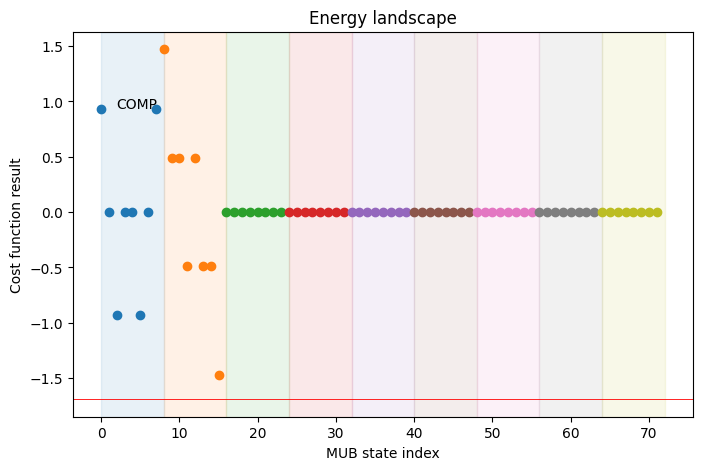

Energy Histogram:


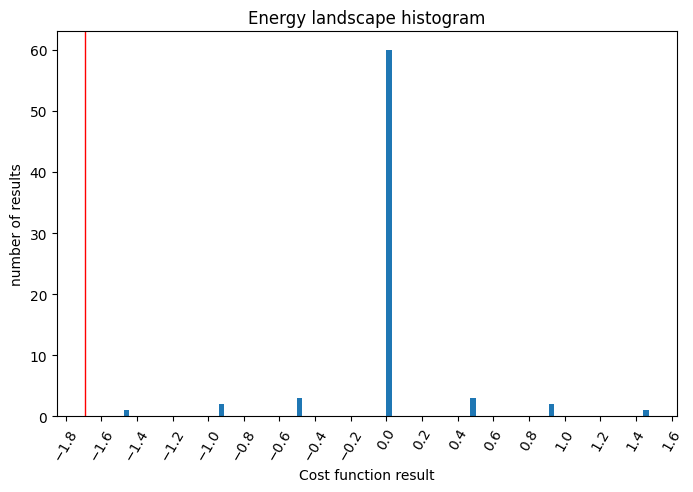

attempting all MUB states over the operator SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IIX'],
              coeffs=[0.86686565+0.j, 0.86686565+0.j, 0.23666449+0.j, 0.23666449+0.j,
 0.23666449+0.j])
Energy Landscape:


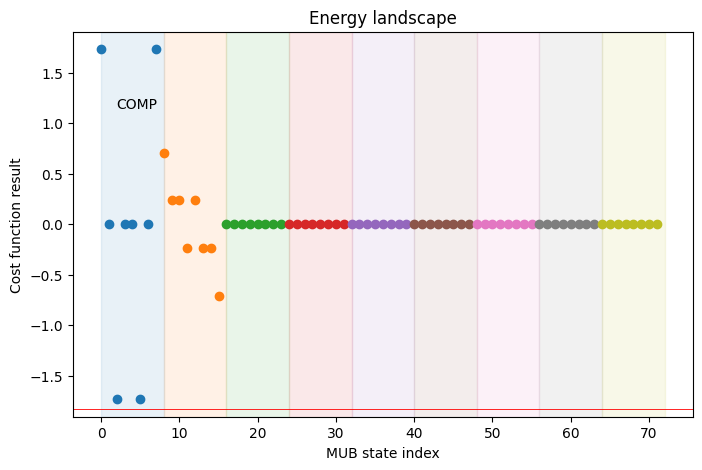

Energy Histogram:


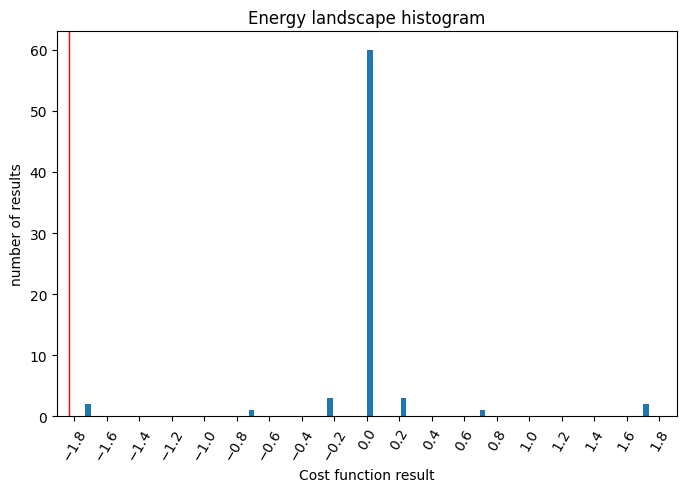

In [34]:
# 3-qubit experiments
n_qubits = 3
n_mub_qubits = 3

for _ in range(3):  # Three examples
    zz_coeff = random.uniform(0,1)
    x_coeff = random.uniform(0,1)
    op = gen_trans_ising_op(n_qubits, zz_coeff, x_coeff)
    print(f"attempting all MUB states over the operator {op}")
    results = calculate_energy_landscape(op, n_mub_qubits, generate_all_subsets(n_mub_qubits, n_qubits))
    exact_result = get_exact_ground(op)
    print("Energy Landscape:")
    display_energy_landscape(results, exact_result=exact_result)
    print("Energy Histogram:")
    display_energy_histogram(results, exact_result=exact_result)

attempting all MUB states over the operator SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[0.11795421+0.j, 0.11795421+0.j, 0.11795421+0.j, 0.74484876+0.j,
 0.74484876+0.j, 0.74484876+0.j, 0.74484876+0.j])
Energy Landscape:


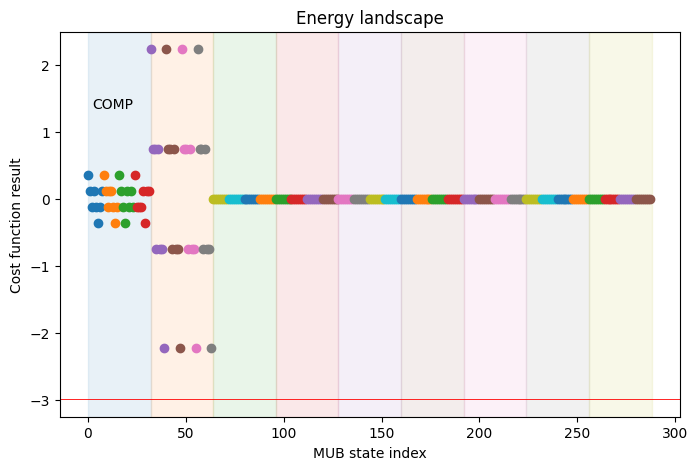

Energy Histogram:


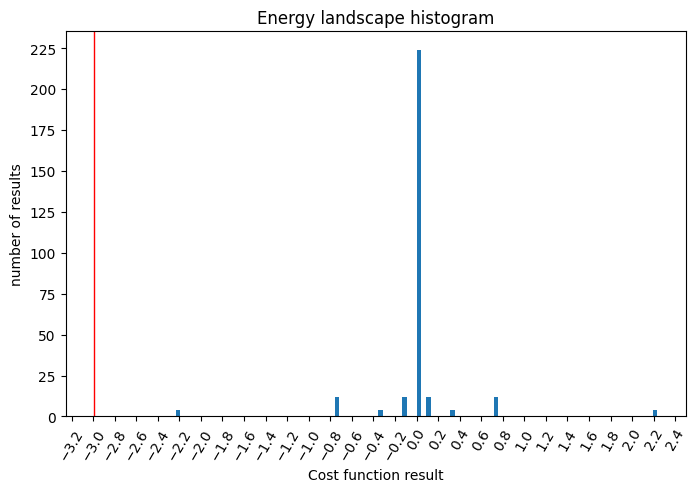

attempting all MUB states over the operator SparsePauliOp(['ZZIII', 'IZZII', 'IIZZI', 'IIIZZ', 'XIIII', 'IXIII', 'IIXII', 'IIIXI', 'IIIIX'],
              coeffs=[0.11795421+0.j, 0.11795421+0.j, 0.11795421+0.j, 0.11795421+0.j,
 0.74484876+0.j, 0.74484876+0.j, 0.74484876+0.j, 0.74484876+0.j,
 0.74484876+0.j])
Energy Landscape:


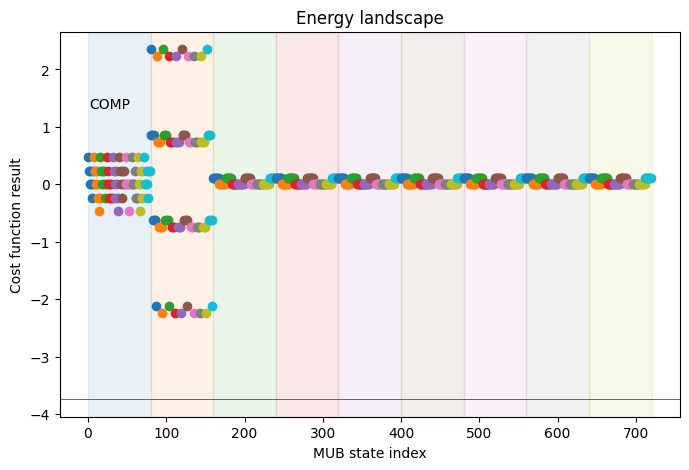

Energy Histogram:


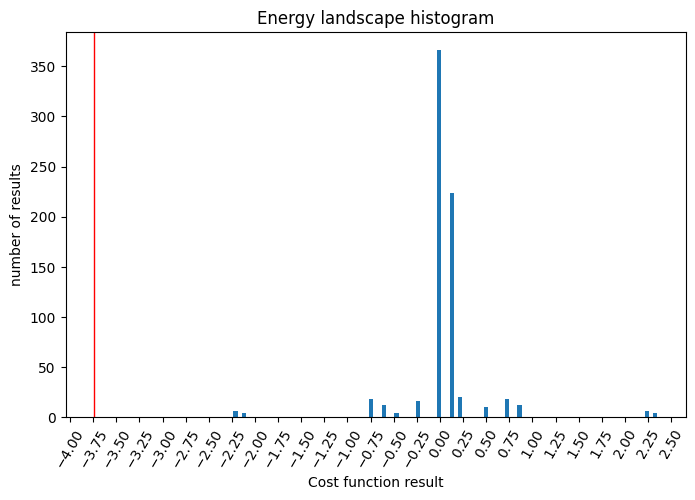

attempting all MUB states over the operator SparsePauliOp(['ZZIIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ', 'XIIIII', 'IXIIII', 'IIXIII', 'IIIXII', 'IIIIXI', 'IIIIIX'],
              coeffs=[0.11795421+0.j, 0.11795421+0.j, 0.11795421+0.j, 0.11795421+0.j,
 0.11795421+0.j, 0.74484876+0.j, 0.74484876+0.j, 0.74484876+0.j,
 0.74484876+0.j, 0.74484876+0.j, 0.74484876+0.j])
Energy Landscape:


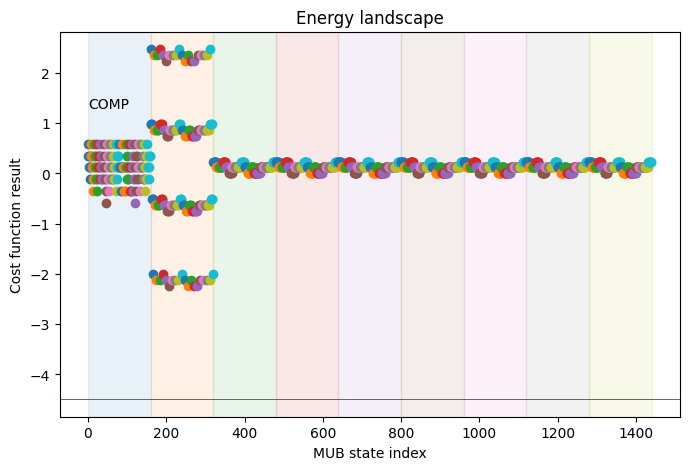

Energy Histogram:


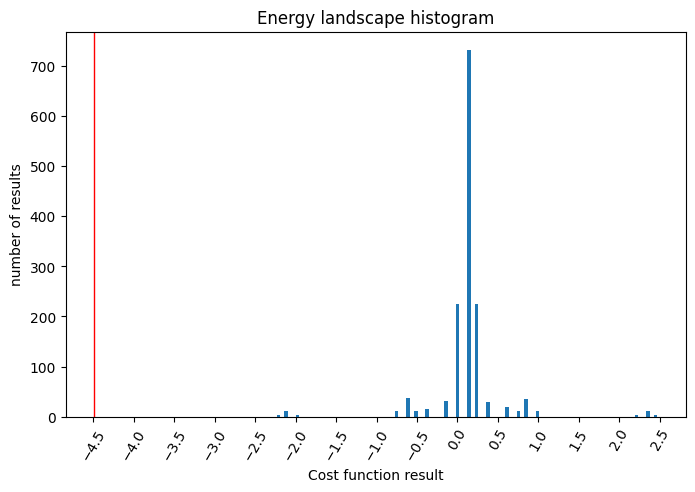

attempting all MUB states over the operator SparsePauliOp(['ZZIIIII', 'IZZIIII', 'IIZZIII', 'IIIZZII', 'IIIIZZI', 'IIIIIZZ', 'XIIIIII', 'IXIIIII', 'IIXIIII', 'IIIXIII', 'IIIIXII', 'IIIIIXI', 'IIIIIIX'],
              coeffs=[0.11795421+0.j, 0.11795421+0.j, 0.11795421+0.j, 0.11795421+0.j,
 0.11795421+0.j, 0.11795421+0.j, 0.74484876+0.j, 0.74484876+0.j,
 0.74484876+0.j, 0.74484876+0.j, 0.74484876+0.j, 0.74484876+0.j,
 0.74484876+0.j])
Energy Landscape:


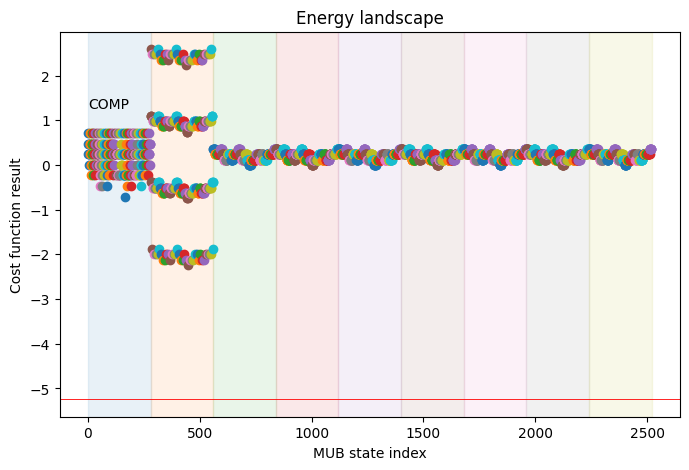

Energy Histogram:


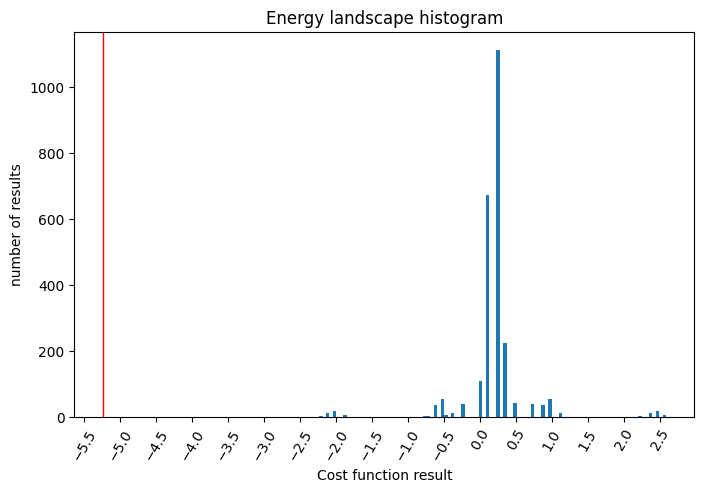

In [35]:
# half-MUB experiments
n_mub_qubits = 3
zz_coeff = random.uniform(0,1)
x_coeff = random.uniform(0,1)

for n_qubits in range(4,8):  # Three examples

    op = gen_trans_ising_op(n_qubits, zz_coeff, x_coeff)
    print(f"attempting all MUB states over the operator {op}")
    results = calculate_energy_landscape(op, n_mub_qubits, generate_all_subsets(n_mub_qubits, n_qubits))
    exact_result = get_exact_ground(op)
    print("Energy Landscape:")
    display_energy_landscape(results, exact_result=exact_result)
    print("Energy Histogram:")
    display_energy_histogram(results, exact_result=exact_result)

### Unified results: partial-MUB with $\ket{0}$ vs. $\ket{+}$
Here, I run the same experiment with a bit less qubits, but use both options forn qubits not involved in the MUB state itself.
1.  Put it in $\ket{0}$, the trivial option.
2.  Put it in $\ket{+}$, the other option Dekel found to be rather successful.

THE ZERO EXPERIMENTS START
attempting all MUB states over the operator Spin Operator
spin=1/2, number spins=4, number terms=7
  0.061137029720259584 * ( Z_0 Z_1 )
+ 0.061137029720259584 * ( Z_1 Z_2 )
+ 0.061137029720259584 * ( Z_2 Z_3 )
+ 0.5762057629441836 * ( X_0 )
+ 0.5762057629441836 * ( X_1 )
+ 0.5762057629441836 * ( X_2 )
+ 0.5762057629441836 * ( X_3 )
========ZERO VERSION=========
Energy Landscape:


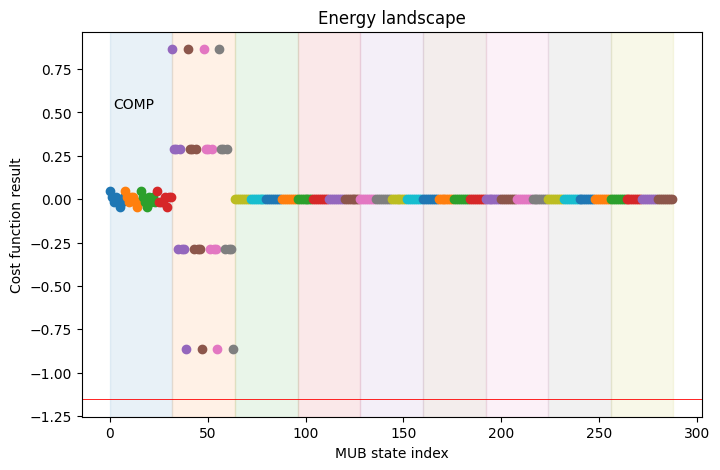

Energy Histogram:


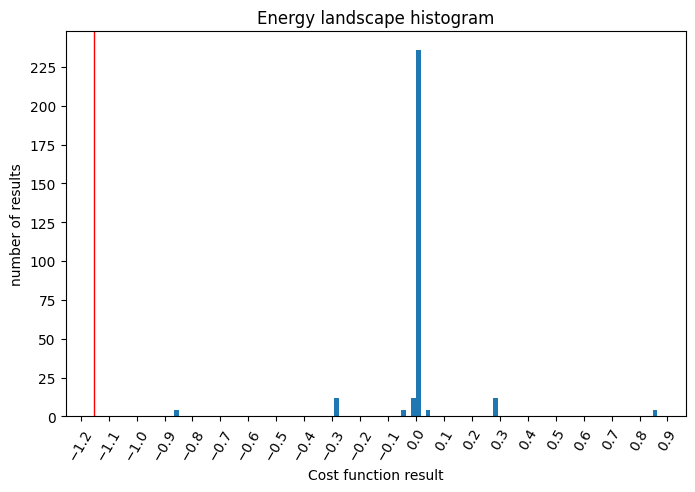

========PLUS VERSION=========
Energy Landscape:


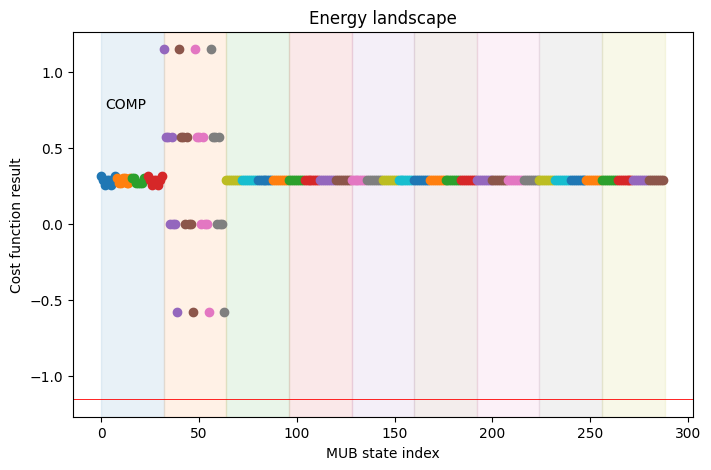

Energy Histogram:


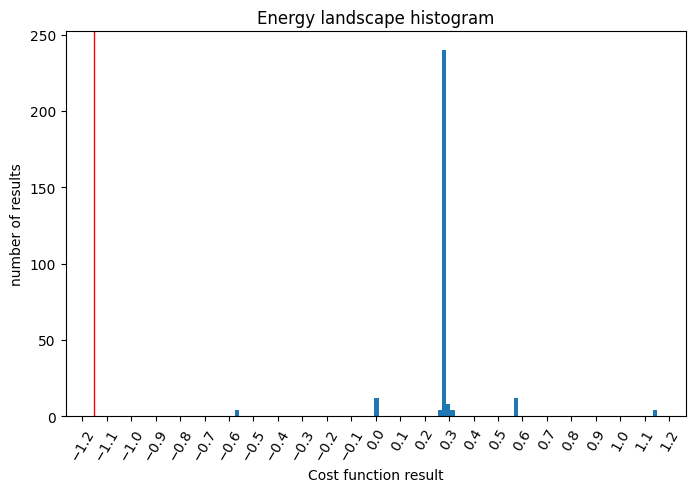

==============END============
attempting all MUB states over the operator Spin Operator
spin=1/2, number spins=5, number terms=9
  0.061137029720259584 * ( Z_0 Z_1 )
+ 0.061137029720259584 * ( Z_1 Z_2 )
+ 0.061137029720259584 * ( Z_2 Z_3 )
+ 0.061137029720259584 * ( Z_3 Z_4 )
+ 0.5762057629441836 * ( X_0 )
+ 0.5762057629441836 * ( X_1 )
+ 0.5762057629441836 * ( X_2 )
+ 0.5762057629441836 * ( X_3 )
+ 0.5762057629441836 * ( X_4 )
========ZERO VERSION=========
Energy Landscape:


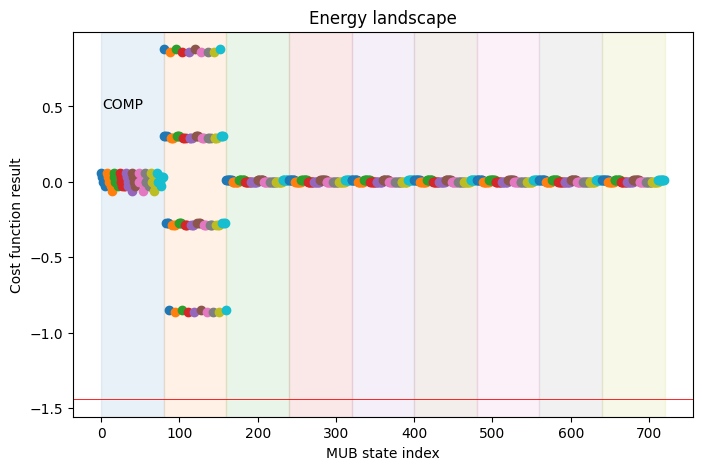

Energy Histogram:


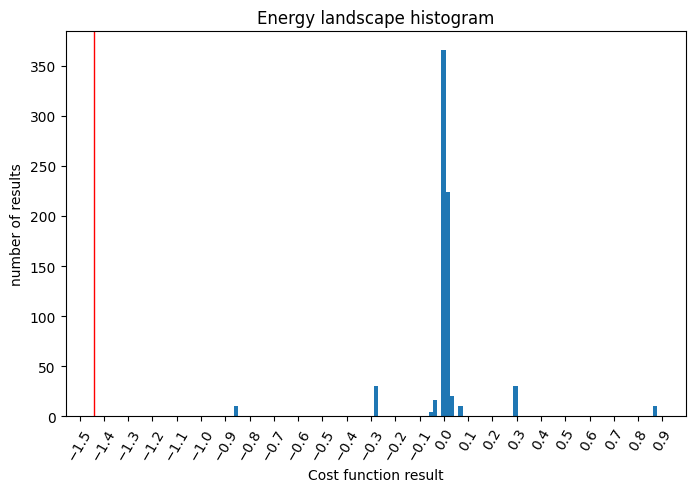

========PLUS VERSION=========
Energy Landscape:


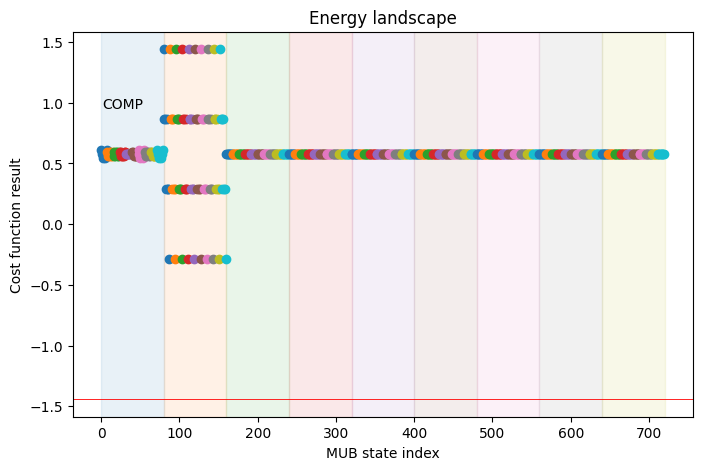

Energy Histogram:


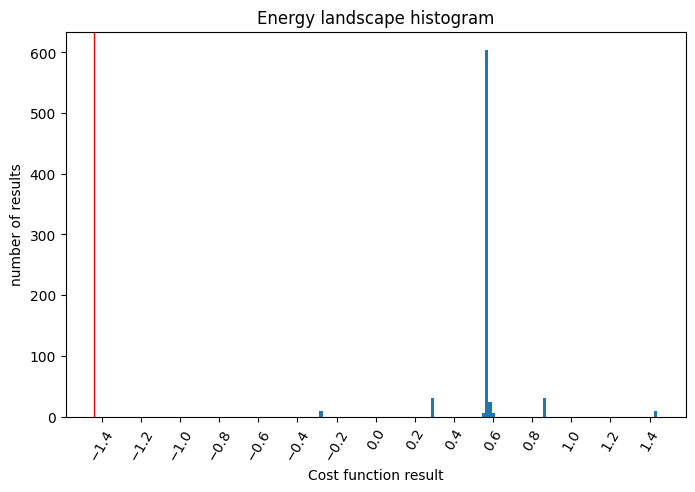

==============END============
attempting all MUB states over the operator Spin Operator
spin=1/2, number spins=6, number terms=11
  0.061137029720259584 * ( Z_0 Z_1 )
+ 0.061137029720259584 * ( Z_1 Z_2 )
+ 0.061137029720259584 * ( Z_2 Z_3 )
+ 0.061137029720259584 * ( Z_3 Z_4 )
+ 0.061137029720259584 * ( Z_4 Z_5 )
+ 0.5762057629441836 * ( X_0 )
+ 0.5762057629441836 * ( X_1 )
+ 0.5762057629441836 * ( X_2 )
+ 0.5762057629441836 * ( X_3 )
+ 0.5762057629441836 * ( X_4 )
+ 0.5762057629441836 * ( X_5 )
========ZERO VERSION=========
Energy Landscape:


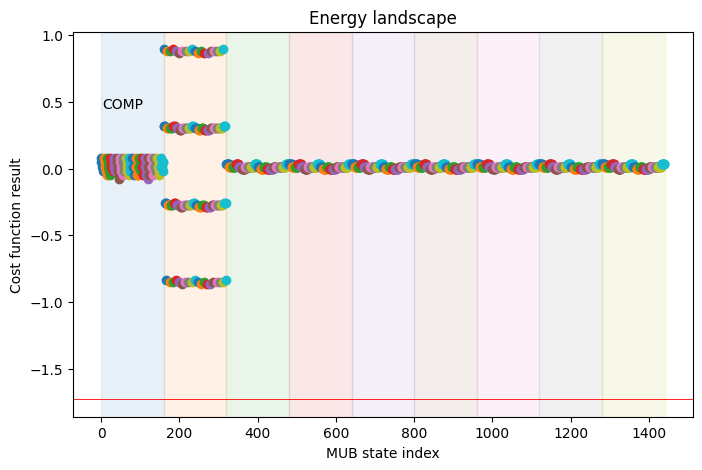

Energy Histogram:


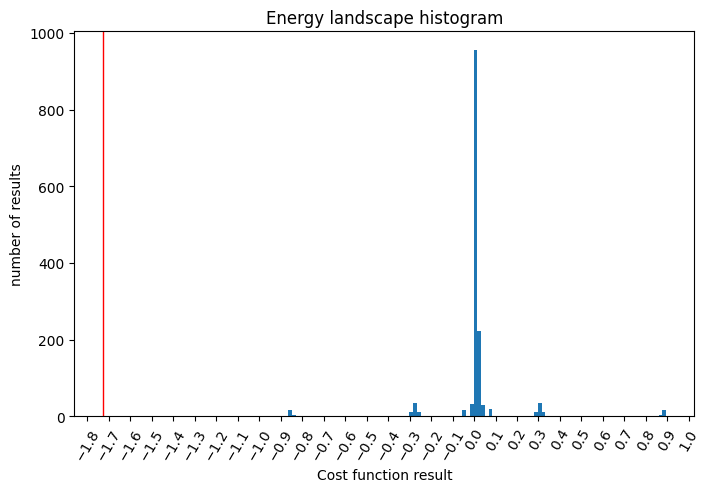

========PLUS VERSION=========
Energy Landscape:


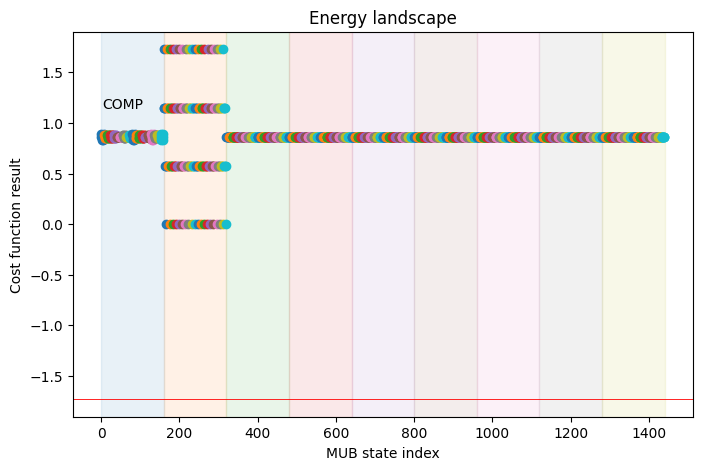

Energy Histogram:


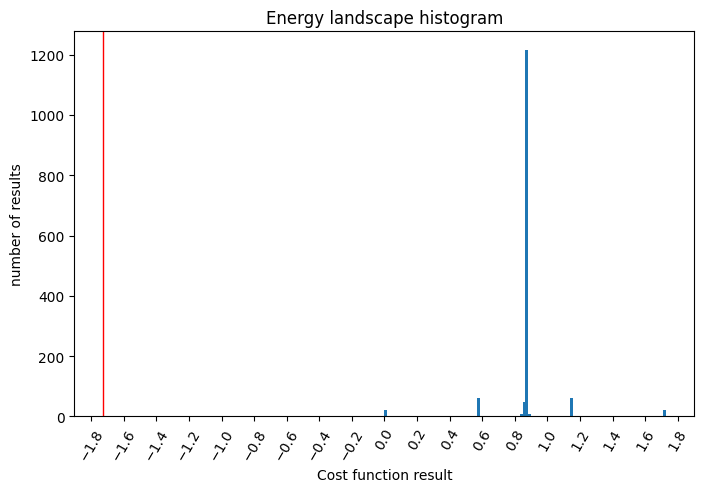

==============END============


In [19]:
# half-MUB experiments
n_mub_qubits = 3
zz_coeff = random.uniform(0,1)
x_coeff = random.uniform(0,1)

print("THE ZERO EXPERIMENTS START")
for n_qubits in range(4,7):  # Three examples
    op = gen_trans_ising_op(n_qubits, zz_coeff, x_coeff)
    print(f"attempting all MUB states over the operator {op}")
    print("========ZERO VERSION=========")
    results = calculate_energy_landscape(op, n_mub_qubits, generate_all_subsets(n_mub_qubits, n_qubits))
    exact_result = get_exact_ground(op)
    print("Energy Landscape:")
    display_energy_landscape(results, exact_result=exact_result)
    print("Energy Histogram:")
    display_energy_histogram(results, exact_result=exact_result)
    print("========PLUS VERSION=========")
    results = calculate_energy_landscape(op, n_mub_qubits, generate_all_subsets(n_mub_qubits, n_qubits), plus_for_non_mub=True)
    exact_result = get_exact_ground(op)
    print("Energy Landscape:")
    display_energy_landscape(results, exact_result=exact_result)
    print("Energy Histogram:")
    display_energy_histogram(results, exact_result=exact_result)
    print("==============END============")


# Execute VQE

I'm using the code from the VQC project.
It's much more complex than I remember it, but I also remember that there is a valid reason for all the funky parameters.
The main reason is how finicky optimizers can be in these tasks.


### Experiment Paremeters and Hyper-parameters

In [93]:
class Parameters:
    def __init__(self, n_qubits: int, n_layers: int, optimizer: str, tol: float, success_bound: float, k: int, exact_result=None):
        self.n_qubits = n_qubits            # number of qubist in the operator
        self.n_layers = n_layers            # number of ansatz layers
        self.optimizer = optimizer          # name of optimizer
        self.tol = tol                      # optimizer "tolerance" parameter. Semantic meaning differs between optimizers.
        self.success_bound = success_bound  # distance from exact result that we consider as success. NOT YET IMPLEMENTED HERE
        self.k = k                          # NOT SURE YET.
        self.exact_result = exact_result    # the exact result that we compare ourselves to.

def get_std_params_3_qubits():
    return Parameters(n_qubits=3, n_layers=5, optimizer='COBYLA', tol=1e-6, success_bound=1e-4, k=25)

def get_std_params_7_qubits():
    return Parameters(n_qubits=7, n_layers=5, optimizer='COBYLA', tol=1e-6, success_bound=1e-4, k=25)

In [97]:
def run_vqe_experiment(hamiltonian: SparsePauliOp, initial_state: QuantumCircuit, params: Parameters) -> tuple[int, float, bool]:
    # preparing the VQE components
    estimator_obj = Estimator()  # Internal qiskit structure
    ansatz = EfficientSU2(
        num_qubits=params.n_qubits, \
        reps=params.n_layers, \
        initial_state=initial_state
    )
    optimizer_obj = COBYLA(
        maxiter = 1000, \
        tol = params.tol \
    )
    # enforcing the success bound
    class BoundHitException(Exception):
        def __init__(self, n_evals, final_cost):
            self.n_evals = n_evals
            self.final_cost = final_cost
    def callback(eval_count: int, theta: np.ndarray, cost: float, metadata: dict) -> None:
        if (eval_count % 100 == 0):
            print(f"{eval_count}: {cost}")
        if (cost < params.exact_result + params.success_bound):
            raise BoundHitException(eval_count, cost)
    
    try:
        vqe_obj = VQE(estimator=estimator_obj, ansatz=ansatz, optimizer=optimizer_obj, callback=callback)
        res = vqe_obj.compute_minimum_eigenvalue(operator=hamiltonian)
        return res.cost_function_evals, res.optimal_value, False
    except BoundHitException as e:
        return e.n_evals, e.final_cost, True

In [95]:
op = gen_trans_ising_op(3,0.1,0.6)
params = get_std_params_3_qubits()
params.exact_result = get_exact_ground(op)
print(run_vqe_experiment(op, QuantumCircuit(3), params))
print(params.exact_result)

100: -1.6581826079245405
200: -1.804594631727319
300: -1.8077175917666604
(397, -1.8082411879470763, True)
-1.8083332335604079
